# Pupular Data Science Questions

For this project, we are working for a company that generates content and wants to write about data science. They want to start a new blog or a social media account and thus, they are wondering what topics they should we write about.

To answer this question we have been asked to figure out a way to find the most populat topics in datascience.

For this we will analyze the posts in Data Science Stack Exchange's website and find out what are the most popular topics. 



## Exploring Data Science Stack Exchange's database 
Stack Exchange Data Explorer (SEDE)
https://data.stackexchange.com/datascience/query/new 

We use "Viewing query" to explore the data and select the columns that we want  to use for our project.



Then we download the data as .csv to use.


In [1]:
"""
SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags,
        AnswerCount, FavoriteCount
FROM Posts
WHERE CreationDate < '2020-01-01' 
      AND Posts.CreationDate > '2018-12-31';
"""

'\nSELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount\nFROM Posts;\n\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:


questions = pd.read_csv("2019_questions.csv", parse_dates=['CreationDate'])
print(questions.head())

      Id        CreationDate  Score  ViewCount  \
0  44419 2019-01-23 09:21:13      1         21   
1  44420 2019-01-23 09:34:01      0         25   
2  44423 2019-01-23 09:58:41      2       1651   
3  44427 2019-01-23 10:57:09      0         55   
4  44428 2019-01-23 11:02:15      0         19   

                                                Tags  AnswerCount  \
0                    <machine-learning><data-mining>            0   
1  <machine-learning><regression><linear-regressi...            0   
2       <python><time-series><forecast><forecasting>            0   
3              <machine-learning><scikit-learn><pca>            1   
4           <dataset><bigdata><data><speech-to-text>            0   

   FavoriteCount  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


In [4]:
questions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


## Cleaning data


In [5]:
# Count each value in FavouriteCount:
print(questions['FavoriteCount'].value_counts(dropna=False))

#Find null values in FavouriteCount. Not all questions are sobemody's favourite
nan = questions['FavoriteCount'].isna().sum()

print("nan values:")
print(+nan)


NaN      7432
 1.0      953
 2.0      205
 0.0      175
 3.0       43
 4.0       12
 5.0        8
 6.0        4
 7.0        4
 11.0       1
 8.0        1
 16.0       1
Name: FavoriteCount, dtype: int64
nan values:
7432


There are many posts that have between 1 and 4 favourite votes, and only a few that have between 5 and 16 votes. 
Since there are many null values, we could transform them to 0 values, since it is the same in this case. 

In [6]:
#Fill missing values in favourite count with 0
questions['FavoriteCount'] = questions['FavoriteCount'].fillna(0).astype(int)

#Check for missing values and confirm operation
print("nan values:")
print(questions['FavoriteCount'].isna().sum())

print("Value counts:")
print(questions['FavoriteCount'].value_counts(dropna=False))

nan values:
0
Value counts:
0     7607
1      953
2      205
3       43
4       12
5        8
7        4
6        4
11       1
16       1
8        1
Name: FavoriteCount, dtype: int64


In [7]:
#Convert creation date to datetime object
questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])


In [8]:
#Check data 
questions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


In [9]:
#Clean de Tags column 
questions['Tags'] = questions['Tags'].str.replace('><', ",").str.replace('<', '').str.replace('>', '')
print(questions['Tags'].head(5))


0                         machine-learning,data-mining
1    machine-learning,regression,linear-regression,...
2              python,time-series,forecast,forecasting
3                    machine-learning,scikit-learn,pca
4                  dataset,bigdata,data,speech-to-text
Name: Tags, dtype: object


In [10]:
# Transform the values in the tag columns to a list of lists
questions['Tags'] = questions['Tags'].str.split(',')
print(questions['Tags'].head())

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object


## Most Used and Most Viewed tags

Now that we cleaned the data, we need to determine the most popular tags based on two different popularity proxies: 
- how many times the tag was used
- and how many times a question with that tag was viewed.

In [12]:
# Count how many times each tag was used.
tag_count = dict()
for tag_list in questions['Tags']:
    for tag in tag_list:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
            
# convert the dictionary into a dataframe
tag_count_df = pd.DataFrame(list(tag_count.items()), columns = ['tag_name','tag_count'])

# get top 10 most popular tags
top_10_used = tag_count_df.sort_values("tag_count", ascending=False).head(10)

top_10_used

,tag_name,tag_count
298,machine-learning,2693
311,python,1814
48,deep-learning,1220
207,neural-network,1055
263,keras,935
371,classification,685
461,tensorflow,584
286,scikit-learn,540
157,nlp,493
77,cnn,489


In [13]:
# Count how many times each tag was viewed

tag_views = dict()

for index, row in questions.iterrows():
    # loop through the list of each row
    for tag in row['Tags']:
        # check if the tag is in the dictionary and add the values
        if tag in tag_views:
            tag_views[tag] += row['ViewCount']
        else:
            tag_views[tag] = row['ViewCount']

# convert the dictionary into a dataframe
tag_views_df =  pd.DataFrame(list(tag_views.items()), columns = ['tag_name','view_count'])

# get top 10 most viewed tags
top_10_viewed = tag_views_df.sort_values("view_count", ascending=False).head(10)

top_10_viewed

,tag_name,view_count
311,python,537585
298,machine-learning,388499
263,keras,268608
48,deep-learning,233628
510,pandas,201787
207,neural-network,185367
286,scikit-learn,128110
461,tensorflow,121369
371,classification,104457
252,dataframe,89352


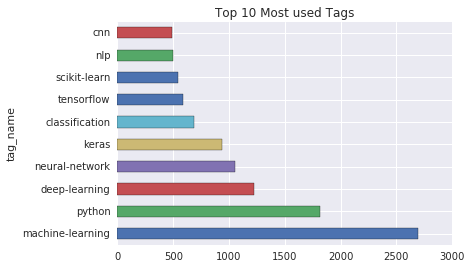

In [14]:
# Visualizations for the top tags of each of the above results.

# Bar plot for the top 10 most popular tags
top_10_used.plot(kind = 'barh', x = 'tag_name', y = 'tag_count', legend = False, title = 'Top 10 Most used Tags')
plt.show()

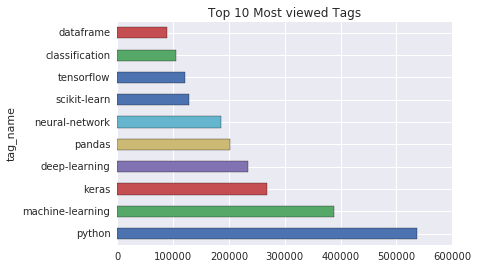

In [15]:
# Bar plot for the top 10 most viewed tags

top_10_viewed.plot(kind = 'barh', x = 'tag_name', y = 'view_count', legend = False, title = 'Top 10 Most viewed Tags')
plt.show()

## Relations Between Tags



In [17]:
# Create a dataframe with the top 20 most used and most viewed tags
most_viewed = tag_views_df.sort_values("view_count", ascending=False).head(20)
most_used = tag_count_df.sort_values("tag_count", ascending=False).head(20)

# set tag_name as index
most_viewed.set_index("tag_name", inplace=True)
most_used.set_index("tag_name", inplace=True)

In [20]:
# Find which tags are in most_used, but not in most_viewed
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used

,tag_count,view_count
tag_name,,
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0


In [21]:
# Find which tags are in most_viewed, but not in most_used
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed

,tag_count,view_count
tag_name,,
python,1814.0,537585
machine-learning,2693.0,388499
keras,935.0,268608
deep-learning,1220.0,233628
pandas,354.0,201787
neural-network,1055.0,185367
scikit-learn,540.0,128110
tensorflow,584.0,121369
classification,685.0,104457


The tags present in most_used and not present in most_viewed are:
- machine-learning-model
- statistics
- predictive-modeling
- r

And the tags present in most_viewed but not in most_used are:
- csv
- pytorch
- dataframe

Some tags also stand out as being related. For example, python is related to pandas, as we can find both pythons and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

## Is deep learning just a fad?

After taking a look at the most used and viewed tags, we start to wonder what relationship is there between the most popular tags.
To answer this question, we will analyze all the questions from the SEDE (not just from 2019) to track the interest in deep learning across time. 

We will:
- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of   questions per time period.

In [ ]:
"""
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
 """

In [22]:
# Read the file all_questions.csv into a dataframe.
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [23]:
# clean the Tags column by Removing brackets from Tags columns
all_questions['Tags'] = all_questions['Tags'].str.replace('><', ',').str.replace('<', '').str.replace('>', '')

# split the Tags column into list
all_questions['Tags'] = all_questions['Tags'].str.split(',')

In [24]:
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In [25]:
 # get the latest date in the list
all_questions['CreationDate'].max()

Timestamp('2020-01-19 03:01:03')

In [26]:
 # get the oldest date in the list
all_questions['CreationDate'].min()

Timestamp('2014-05-13 23:58:30')

Based on the previous part of the project, we will take some of the most popular tags that we believe are associated with deep learning to see how many times these tags show up in questions. This will give us a definition of deep learning that we can use to analyze the use of tags in specific time periods.


In [27]:
# Create a list of tags relating to deep-learning topics
deep_learning = ["python",
             "machine-learning",
             "keras",
             "deep-learning",
             "neural-network",
             "scikit-learn",
             "tensorflow",
             "classification"
            ]

# Define a function to check for matches to deep_learning
def deep_tags(row):
    tags = ','.join(row['Tags'])
    for tag in deep_learning:
        if tag in tags:
            return "deep-learning"

    return "Other"

# Apply the  function to create a new column
all_questions['Question_Category'] = all_questions.apply(deep_tags, axis=1)

In [28]:
all_questions.head(10)

,Id,CreationDate,Tags,Question_Category
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",deep-learning
1,45418,2019-02-12 00:50:39,[neural-network],deep-learning
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",deep-learning
3,45426,2019-02-12 04:51:49,[keras],deep-learning
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",deep-learning
5,45428,2019-02-12 05:43:18,[cnn],Other
6,45430,2019-02-12 06:20:30,"[machine-learning, learning]",deep-learning
7,45431,2019-02-12 07:26:56,[machine-learning],deep-learning
8,45433,2019-02-12 08:56:23,"[python, keras, tensorflow, lstm]",deep-learning
9,45434,2019-02-12 09:09:01,"[neural-network, feature-selection, mlp]",deep-learning


In [29]:
# Using the month timeframe to track interest in deep learning
# How many times in a month were tags related to deep learning used ?
all_questions['Creation_Month'] = all_questions['CreationDate'].dt.strftime('%Y%m')
all_questions['Creation_Month'] = pd.to_datetime(all_questions['Creation_Month'], format='%Y%m')

In [30]:
# Count how many deep learning questions are asked all together.
all_questions['Question_Category'].value_counts()

deep-learning    14527
Other             7049
Name: Question_Category, dtype: int64

In [31]:
# Count how many deep learning questions are asked in a month.
grouped = all_questions.groupby(['Creation_Month', 'Question_Category']).size().reset_index(name='Count')

# pivot the table to have columns for each question type
pv_table = grouped.pivot(index='Creation_Month', columns='Question_Category', values='Count')

In [32]:
pv_table.head()

Question_Category,Other,deep-learning
Creation_Month,,
2014-05-01,44,14
2014-06-01,57,42
2014-07-01,37,39
2014-08-01,36,29
2014-09-01,25,23


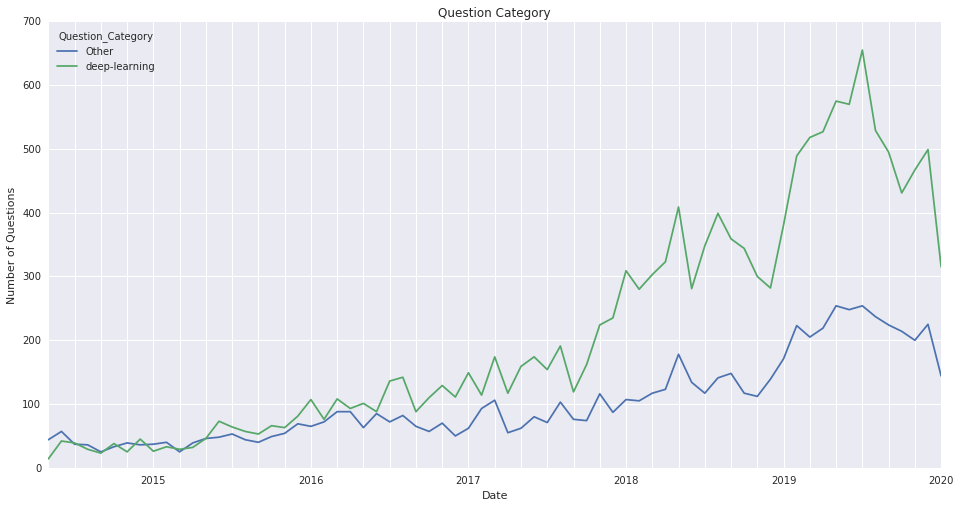

In [33]:
# plot deep learning questions count across each month
ax = pv_table.plot(kind='line', figsize=(16,8))
ax.set_xlabel('Date')
ax.set_ylabel('Number of Questions')
ax.set_title('Question Category')

# set x ticks for every other month
x_ticks = pv_table.index[::2]
ax.set_xticks(x_ticks)

plt.show()

The data clearly shows that people have been asking questions about topics related to deep learning for several years and it seems to be the most adequate  subject to write about. 